In [5]:
library(Seurat)
library(dplyr)
library(ComplexHeatmap)
library(circlize)
library(SeuratDisk)
library(Seurat)
library(dplyr)
library(ggplot2)
library(ComplexHeatmap)
library(circlize)

In [6]:
# hanifa data
obj <- LoadH5Seurat("/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Psoriasis_data/hanifa_data/GITHUB-DATA/SC-RNA-DATA/HANIFFA-DATA/RDS-Files/submission.h5seurat")
# travisdata

# obj <- readRDS("/mnt/home3/miska/nm667/scratch/inProgress/dev/data/Psoriasis_data/hanifa_data/GITHUB-DATA/SC-RNA-DATA/TRAVIS-DATA/RDS-Files/Travis_Data_Seurat_Object.RDS")


Validating h5Seurat file

Initializing RNA with data



Adding counts for RNA

Adding feature-level metadata for RNA

Adding command information

Adding cell-level metadata

Adding miscellaneous information

Adding tool-specific results



Warning message:
“Removing 174729 cells missing data for vars requested”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <93>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <93>

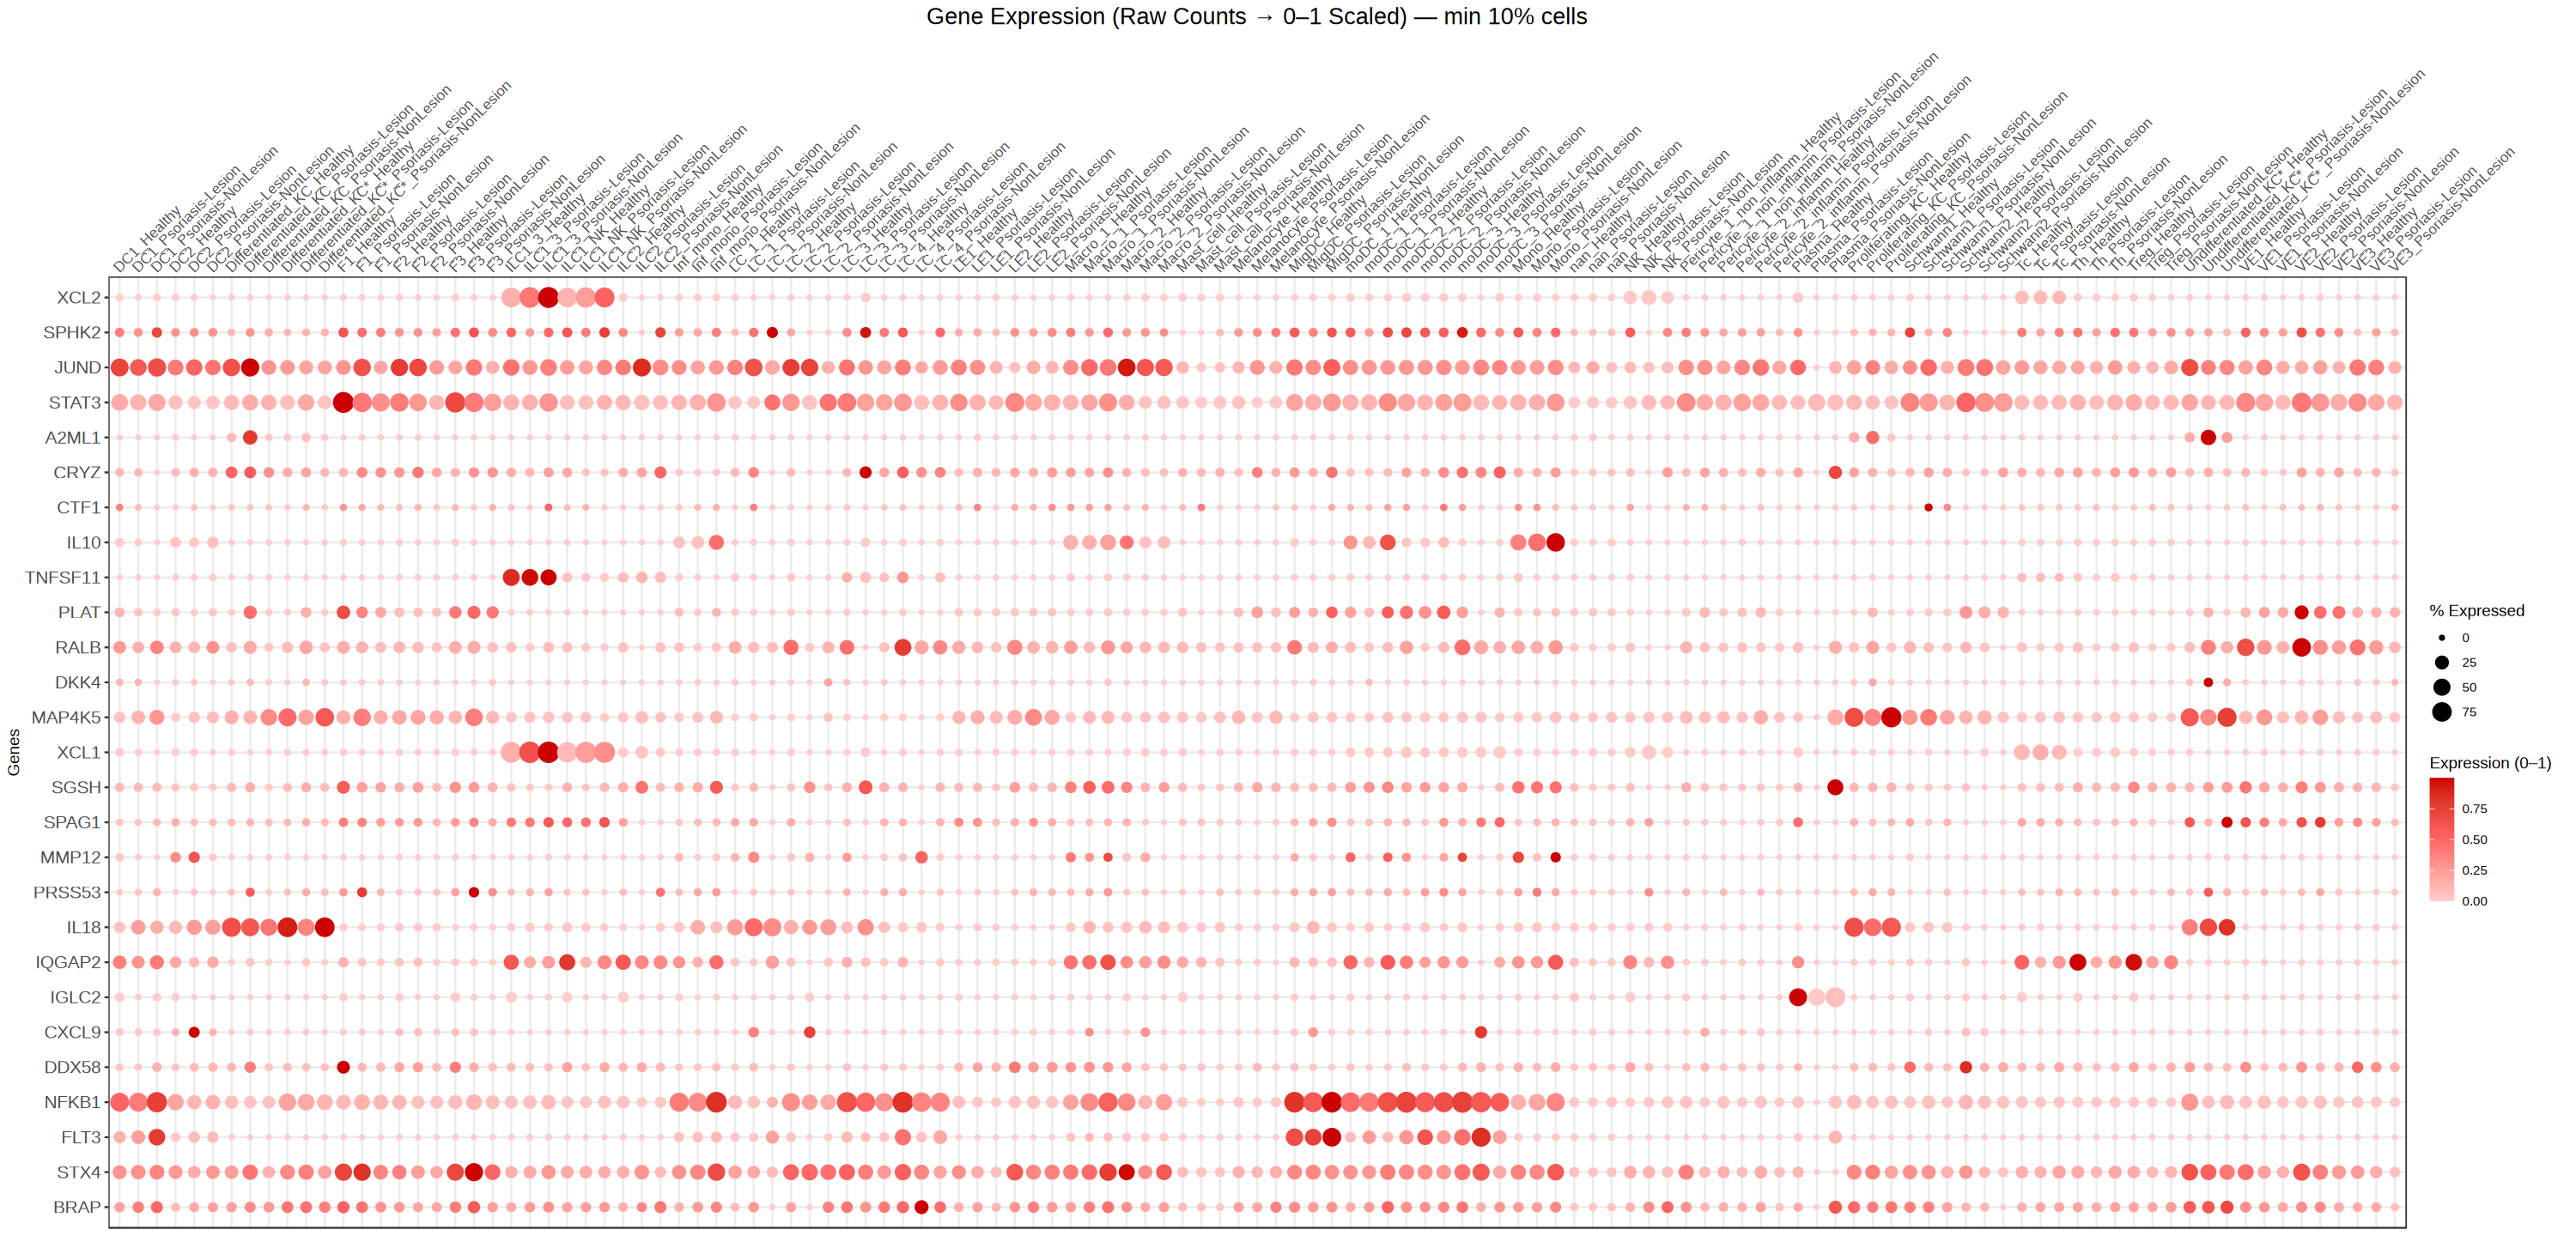

In [7]:
library(Seurat)
library(dplyr)
library(tidyr)
library(ggplot2)

options(repr.plot.width = 26, repr.plot.height = 16)

## ==========================================================
## 1. Genes
## ==========================================================
genes <- c(
    "BRAP", "STX4", "FLT3", "NFKB1", "DDX58", "CXCL9", "IGLC2", "IQGAP2", "IL18",
    "PRSS53", "MMP12", "SPAG1", "SGSH", "XCL1", "MAP4K5", "DKK4", "RALB", "PLAT",
    "TNFSF11", "IL10", "CTF1", "CRYZ", "A2ML1", "STAT3", "JUND", "SPHK2", "XCL2"
)
genes_present <- intersect(genes, rownames(obj))

## ==========================================================
## 2. Setup Condition Labels
## ==========================================================
obj$Condition3 <- NA
obj$Condition3[obj$Status == "Healthy"] <- "Healthy"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "lesion"] <- "Psoriasis-Lesion"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "non_lesion"] <- "Psoriasis-NonLesion"

obj_sub <- subset(obj, Condition3 %in% c("Healthy", "Psoriasis-Lesion", "Psoriasis-NonLesion"))

## Create combined label
obj_sub$CellType_Condition <- paste0(obj_sub$final_clustering, "_", obj_sub$Condition3)

## ==========================================================
## 3. Extract RAW COUNT DATA
## ==========================================================
cnt <- GetAssayData(obj_sub, assay = "RNA", slot = "counts")
cnt <- cnt[genes_present, ]
meta <- obj_sub@meta.data[, c("CellType_Condition"), drop = FALSE]

## ==========================================================
## 4. Compute mean counts + % cells expressing
## ==========================================================
plot_df <- lapply(genes_present, function(g) {
    x <- cnt[g, ]

    df <- data.frame(
        CellTypeCondition = meta$CellType_Condition,
        Count = as.numeric(x)
    ) %>%
        group_by(CellTypeCondition) %>%
        summarise(
            Percent = mean(Count > 0) * 100,
            Expression = mean(Count)
        ) %>%
        mutate(Gene = g)

    df
}) %>% bind_rows()

plot_df[is.na(plot_df)] <- 0

## ==========================================================
## 4.1  FILTER OUT GROUPS < 10% EXPRESSION

## ==========================================================
## REMOVE NA + literal "nan" values + FILTER <10%
## ==========================================================
                 # keep only >=10% expressing


## ==========================================================
## 5. Scale EXPRESSION 0–1 per gene
## ==========================================================
plot_df <- plot_df %>%
    group_by(Gene) %>%
    mutate(Expression01 = (Expression - min(Expression)) /
        (max(Expression) - min(Expression) + 1e-9)) %>%
    ungroup()

plot_df$Gene <- factor(plot_df$Gene, levels = genes_present)
plot_df$CellTypeCondition <- factor(plot_df$CellTypeCondition,
    levels = sort(unique(plot_df$CellTypeCondition))
)

## ==========================================================
## 6. DOT PLOT
## ==========================================================
p <- ggplot(plot_df, aes(
    x = CellTypeCondition,
    y = Gene,
    size = Percent,
    color = Expression01
)) +
    geom_point() +
    scale_size(range = c(1, 6)) +
    scale_color_gradientn(
        colours = c("#FFCCCC", "#FF6666", "#CC0000"),
        values = c(0, 0.5, 1)
    ) +
    theme_bw() +
    theme(
        axis.text.x       = element_blank(),
        axis.title.x      = element_blank(),
        axis.ticks.x      = element_blank(),
        axis.text.x.top   = element_text(angle = 45, hjust = 0, size = 10),
        axis.text.y       = element_text(size = 12),
        plot.title        = element_text(size = 16, hjust = 0.5)
    ) +
    scale_x_discrete(position = "top") +
    labs(
        title = "Gene Expression (Raw Counts → 0–1 Scaled) — min 10% cells",
        x = "Cell Type × Condition",
        y = "Genes",
        size = "% Expressed",
        color = "Expression (0–1)"
    )

options(repr.plot.width = 25, repr.plot.height = 12)
p

## ==========================================================
## 7. Save matrices & plot
## ==========================================================
write.csv(plot_df, "dotplot_matrix_rawcounts_scaled01.csv", row.names = FALSE)

ggsave("dotplot_rawcounts_01scale_min10pct.pdf", p, width = 25, height = 12)
ggsave("dotplot_rawcounts_01scale_min10pct.png", p, width = 25, height = 12, dpi = 300)


Warning message:
“Removing 174729 cells missing data for vars requested”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <93>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <80>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Expression (0–1)' in 'mbcsToSbcs': dot substituted for <93>

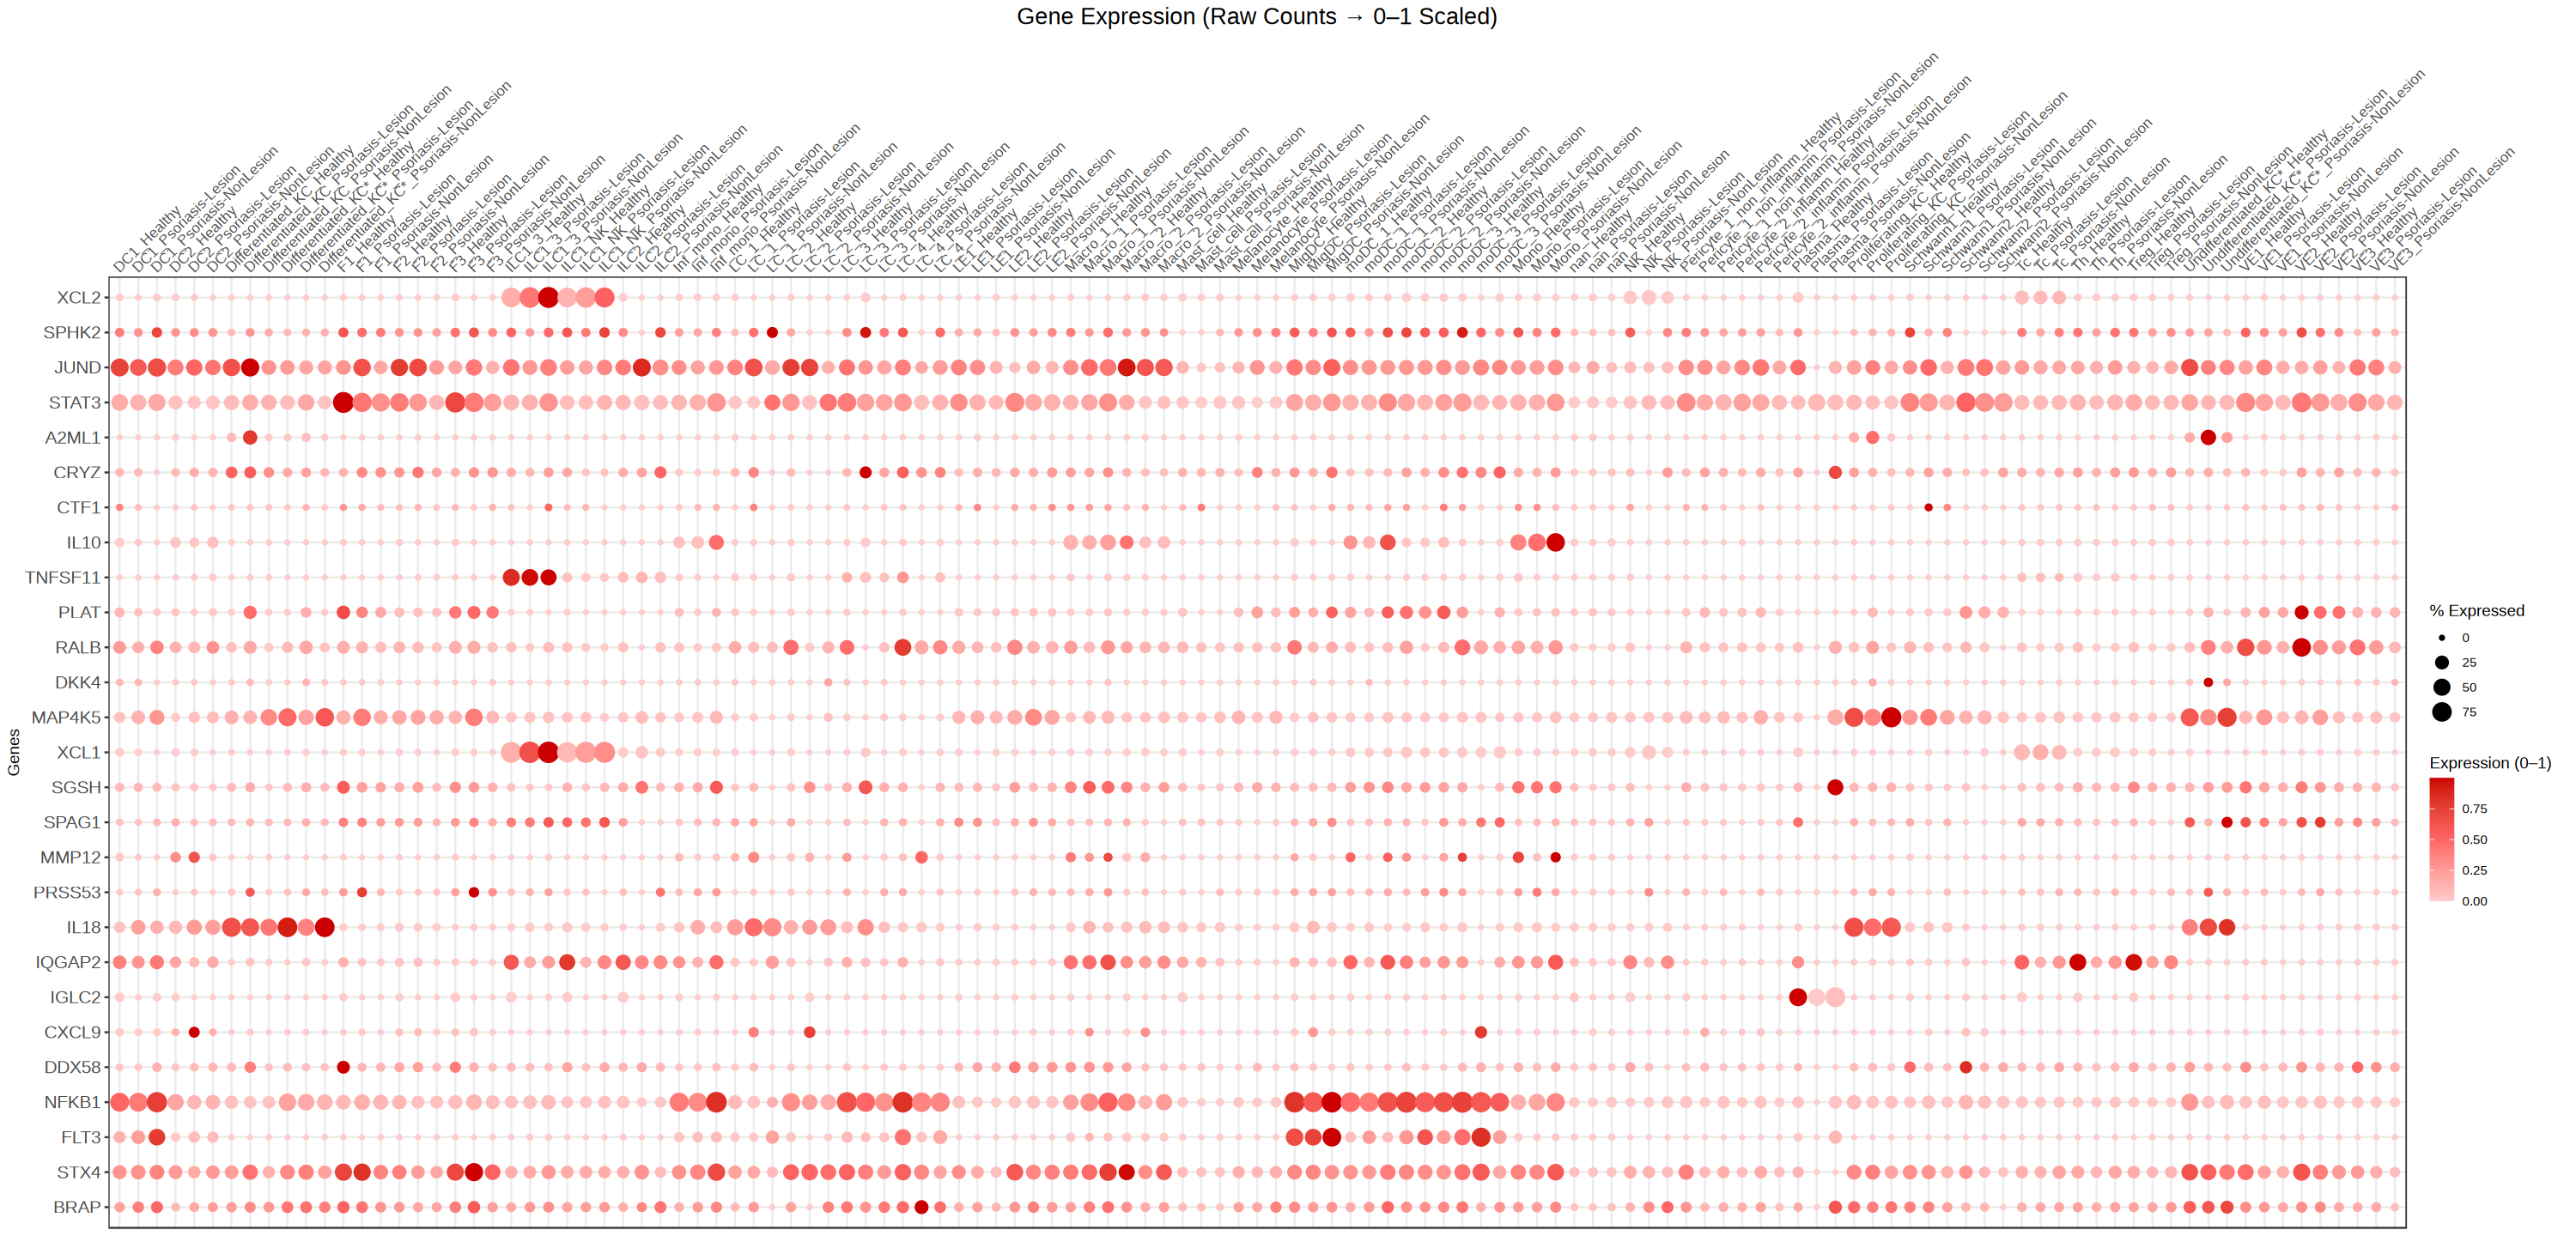

In [8]:
library(Seurat)
library(dplyr)
library(tidyr)
library(ggplot2)

options(repr.plot.width = 26, repr.plot.height = 16)

## ==========================================================
## 1. Genes
## ==========================================================
genes <- c(
    "BRAP", "STX4", "FLT3", "NFKB1", "DDX58", "CXCL9", "IGLC2", "IQGAP2", "IL18",
    "PRSS53", "MMP12", "SPAG1", "SGSH", "XCL1", "MAP4K5", "DKK4", "RALB", "PLAT",
    "TNFSF11", "IL10", "CTF1", "CRYZ", "A2ML1", "STAT3", "JUND", "SPHK2", "XCL2"
)
genes_present <- intersect(genes, rownames(obj))

## ==========================================================
## 2. Setup Condition Labels
## ==========================================================
obj$Condition3 <- NA
obj$Condition3[obj$Status == "Healthy"] <- "Healthy"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "lesion"] <- "Psoriasis-Lesion"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "non_lesion"] <- "Psoriasis-NonLesion"

obj_sub <- subset(obj, Condition3 %in% c("Healthy", "Psoriasis-Lesion", "Psoriasis-NonLesion"))

## Create combined label
obj_sub$CellType_Condition <- paste0(obj_sub$final_clustering, "_", obj_sub$Condition3)

## ==========================================================
## 3. Extract RAW COUNT DATA
## ==========================================================
cnt <- GetAssayData(obj_sub, assay = "RNA", slot = "counts") # sparse matrix

## Keep selected genes only
cnt <- cnt[genes_present, ]

## extract meta (force data.frame!)
meta <- obj_sub@meta.data[, c("CellType_Condition"), drop = FALSE]

## ==========================================================
## 4. Compute mean counts + % cells expressing
## ==========================================================
plot_df <- lapply(genes_present, function(g) {
    x <- cnt[g, ] # counts for gene g

    df <- data.frame(
        CellTypeCondition = meta$CellType_Condition,
        Count = as.numeric(x)
    ) %>%
        group_by(CellTypeCondition) %>%
        summarise(
            Percent = mean(Count > 0) * 100,
            Expression = mean(Count)
        ) %>%
        mutate(Gene = g)

    df
}) %>% bind_rows()

plot_df[is.na(plot_df)] <- 0


## ==========================================================
## 5. Scale EXPRESSION 0–1 per gene (from raw mean counts)
## ==========================================================
plot_df <- plot_df %>%
    group_by(Gene) %>%
    mutate(Expression01 = (Expression - min(Expression)) /
        (max(Expression) - min(Expression) + 1e-9)) %>%
    ungroup()

## ORDERING
plot_df$Gene <- factor(plot_df$Gene, levels = genes_present)
plot_df$CellTypeCondition <- factor(plot_df$CellTypeCondition,
    levels = sort(unique(plot_df$CellTypeCondition))
)

## ==========================================================
## 6. DOT PLOT (0–1 scaled from raw counts)
## ==========================================================
p <- ggplot(plot_df, aes(
    x = CellTypeCondition,
    y = Gene,
    size = Percent,
    color = Expression01
)) +
    geom_point() +
    scale_size(range = c(1, 6)) +
    scale_color_gradientn(
        colours = c("#FFCCCC", "#FF6666", "#CC0000"),
        values = c(0, 0.5, 1)
    ) +
    theme_bw() +
    theme(
        ## MOVE LABELS TO TOP
        axis.text.x       = element_blank(),
        axis.title.x      = element_blank(),
        axis.ticks.x      = element_blank(),
        axis.text.x.top   = element_text(angle = 45, hjust = 0, size = 10),
        axis.text.y       = element_text(size = 12),
        plot.title        = element_text(size = 16, hjust = 0.5)
    ) +
    scale_x_discrete(position = "top") +
    labs(
        title = "Gene Expression (Raw Counts → 0–1 Scaled)",
        x = "Cell Type × Condition",
        y = "Genes",
        size = "% Expressed",
        color = "Expression (0–1)"
    )

options(repr.plot.width = 25, repr.plot.height = 12)
p

## ==========================================================
## 7. Save matrices & plot
## ==========================================================
write.csv(plot_df, "dotplot_matrix_rawcounts_scaled01.csv", row.names = FALSE)

ggsave("dotplot_rawcounts_01scale.pdf", p, width = 25, height = 12)
ggsave("dotplot_rawcounts_01scale.png", p, width = 25, height = 12, dpi = 300)


In [9]:


# ================================================================
# 0. Setup Condition3 EXACTLY as before
# ================================================================
obj$Condition3 <- NA
obj$Condition3[obj$Status == "Healthy"] <- "Healthy"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "lesion"] <- "Psoriasis-Lesion"
obj$Condition3[obj$Status == "Psoriasis" & obj$Site == "non_lesion"] <- "Psoriasis-NonLesion"

obj_sub <- subset(obj, Condition3 %in% c("Healthy", "Psoriasis-Lesion", "Psoriasis-NonLesion"))

# ================================================================
# 1. Your gene list (only DE for these genes)
# ================================================================
genes <- c(
    "BRAP", "STX4", "FLT3", "NFKB1", "DDX58", "CXCL9", "IGLC2", "IQGAP2", "IL18",
    "PRSS53", "MMP12", "SPAG1", "SGSH", "XCL1", "MAP4K5", "DKK4", "RALB", "PLAT",
    "TNFSF11", "IL10", "CTF1", "CRYZ", "A2ML1", "STAT3", "JUND", "SPHK2", "XCL2"
)

genes_present <- intersect(genes, rownames(obj_sub))

# ================================================================
# 2. SAFE DE function — per cell type, ONLY selected genes
# ================================================================
run_de_celltype <- function(seu, celltype, g1, g2, genes_keep) {
    # Check if cell type exists
    if (!celltype %in% seu$final_clustering) {
        message("Skipping ", celltype, " → cell type not present")
        return(NULL)
    }

    # Check cells present for this comparison
    sel_cells <- which(
        seu$final_clustering == celltype &
            seu$Condition3 %in% c(g1, g2)
    )

    if (length(sel_cells) == 0) {
        message("Skipping ", celltype, " | ", g1, " vs ", g2, " → no cells found")
        return(NULL)
    }

    sub <- subset(
        seu,
        final_clustering == celltype &
            Condition3 %in% c(g1, g2)
    )

    # Count cells
    n1 <- sum(sub$Condition3 == g1)
    n2 <- sum(sub$Condition3 == g2)

    if (n1 < 3 || n2 < 3) {
        message(
            "Skipping ", celltype, " | ", g1, " vs ", g2,
            " → insufficient cells (", n1, " vs ", n2, ")"
        )
        return(NULL)
    }

    # Identity groups
    Idents(sub) <- sub$Condition3

    # ------------------------------------------------------------
    # Run DE **ONLY for your selected genes**
    # ------------------------------------------------------------
    df <- FindMarkers(
        sub,
        ident.1 = g1,
        ident.2 = g2,
        features = genes_keep, ## <—— CHANGED HERE
        logfc.threshold = 0,
        test.use = "wilcox",
        assay = "RNA",
        slot = "data"
    )

    df <- df %>%
        mutate(
            Gene = rownames(df),
            Comparison = paste0(g1, " vs ", g2),
            CellType = celltype,
            n_cells_group1 = n1,
            n_cells_group2 = n2,
            condition1 = g1,
            condition2 = g2,
            Significance_Class = case_when(
                p_val_adj < 0.001 ~ "Highly Significant",
                p_val_adj < 0.05 ~ "Significant",
                TRUE ~ "Not Significant"
            )
        )

    rownames(df) <- NULL
    df
}

# ================================================================
# 3. Run DE per cell type × 3 comparisons
# ================================================================
celltypes <- sort(unique(obj_sub$final_clustering))
de_list <- list()

for (ct in celltypes) {
    de_list[[paste0(ct, "_L_vs_H")]] <- run_de_celltype(
        obj_sub, ct,
        "Psoriasis-Lesion", "Healthy",
        genes_present
    )

    de_list[[paste0(ct, "_NL_vs_H")]] <- run_de_celltype(
        obj_sub, ct,
        "Psoriasis-NonLesion", "Healthy",
        genes_present
    )

    de_list[[paste0(ct, "_L_vs_NL")]] <- run_de_celltype(
        obj_sub, ct,
        "Psoriasis-Lesion", "Psoriasis-NonLesion",
        genes_present
    )
}

DE_celltypes <- bind_rows(de_list)

# ================================================================
# 4. SAVE TO CSV
# ================================================================
write.csv(
    DE_celltypes,
    "DE_per_celltype_SELECTED_GENES_conditions_MIN3.csv",
    row.names = FALSE
)

message("DONE: DE per cell type (selected genes only). Saved CSV.")


Warning message:
“Removing 174729 cells missing data for vars requested”


Skipping Plasma | Psoriasis-Lesion vs Healthy → insufficient cells (2 vs 71)

Skipping Plasma | Psoriasis-Lesion vs Psoriasis-NonLesion → insufficient cells (2 vs 5)

DONE: DE per cell type (selected genes only). Saved CSV.



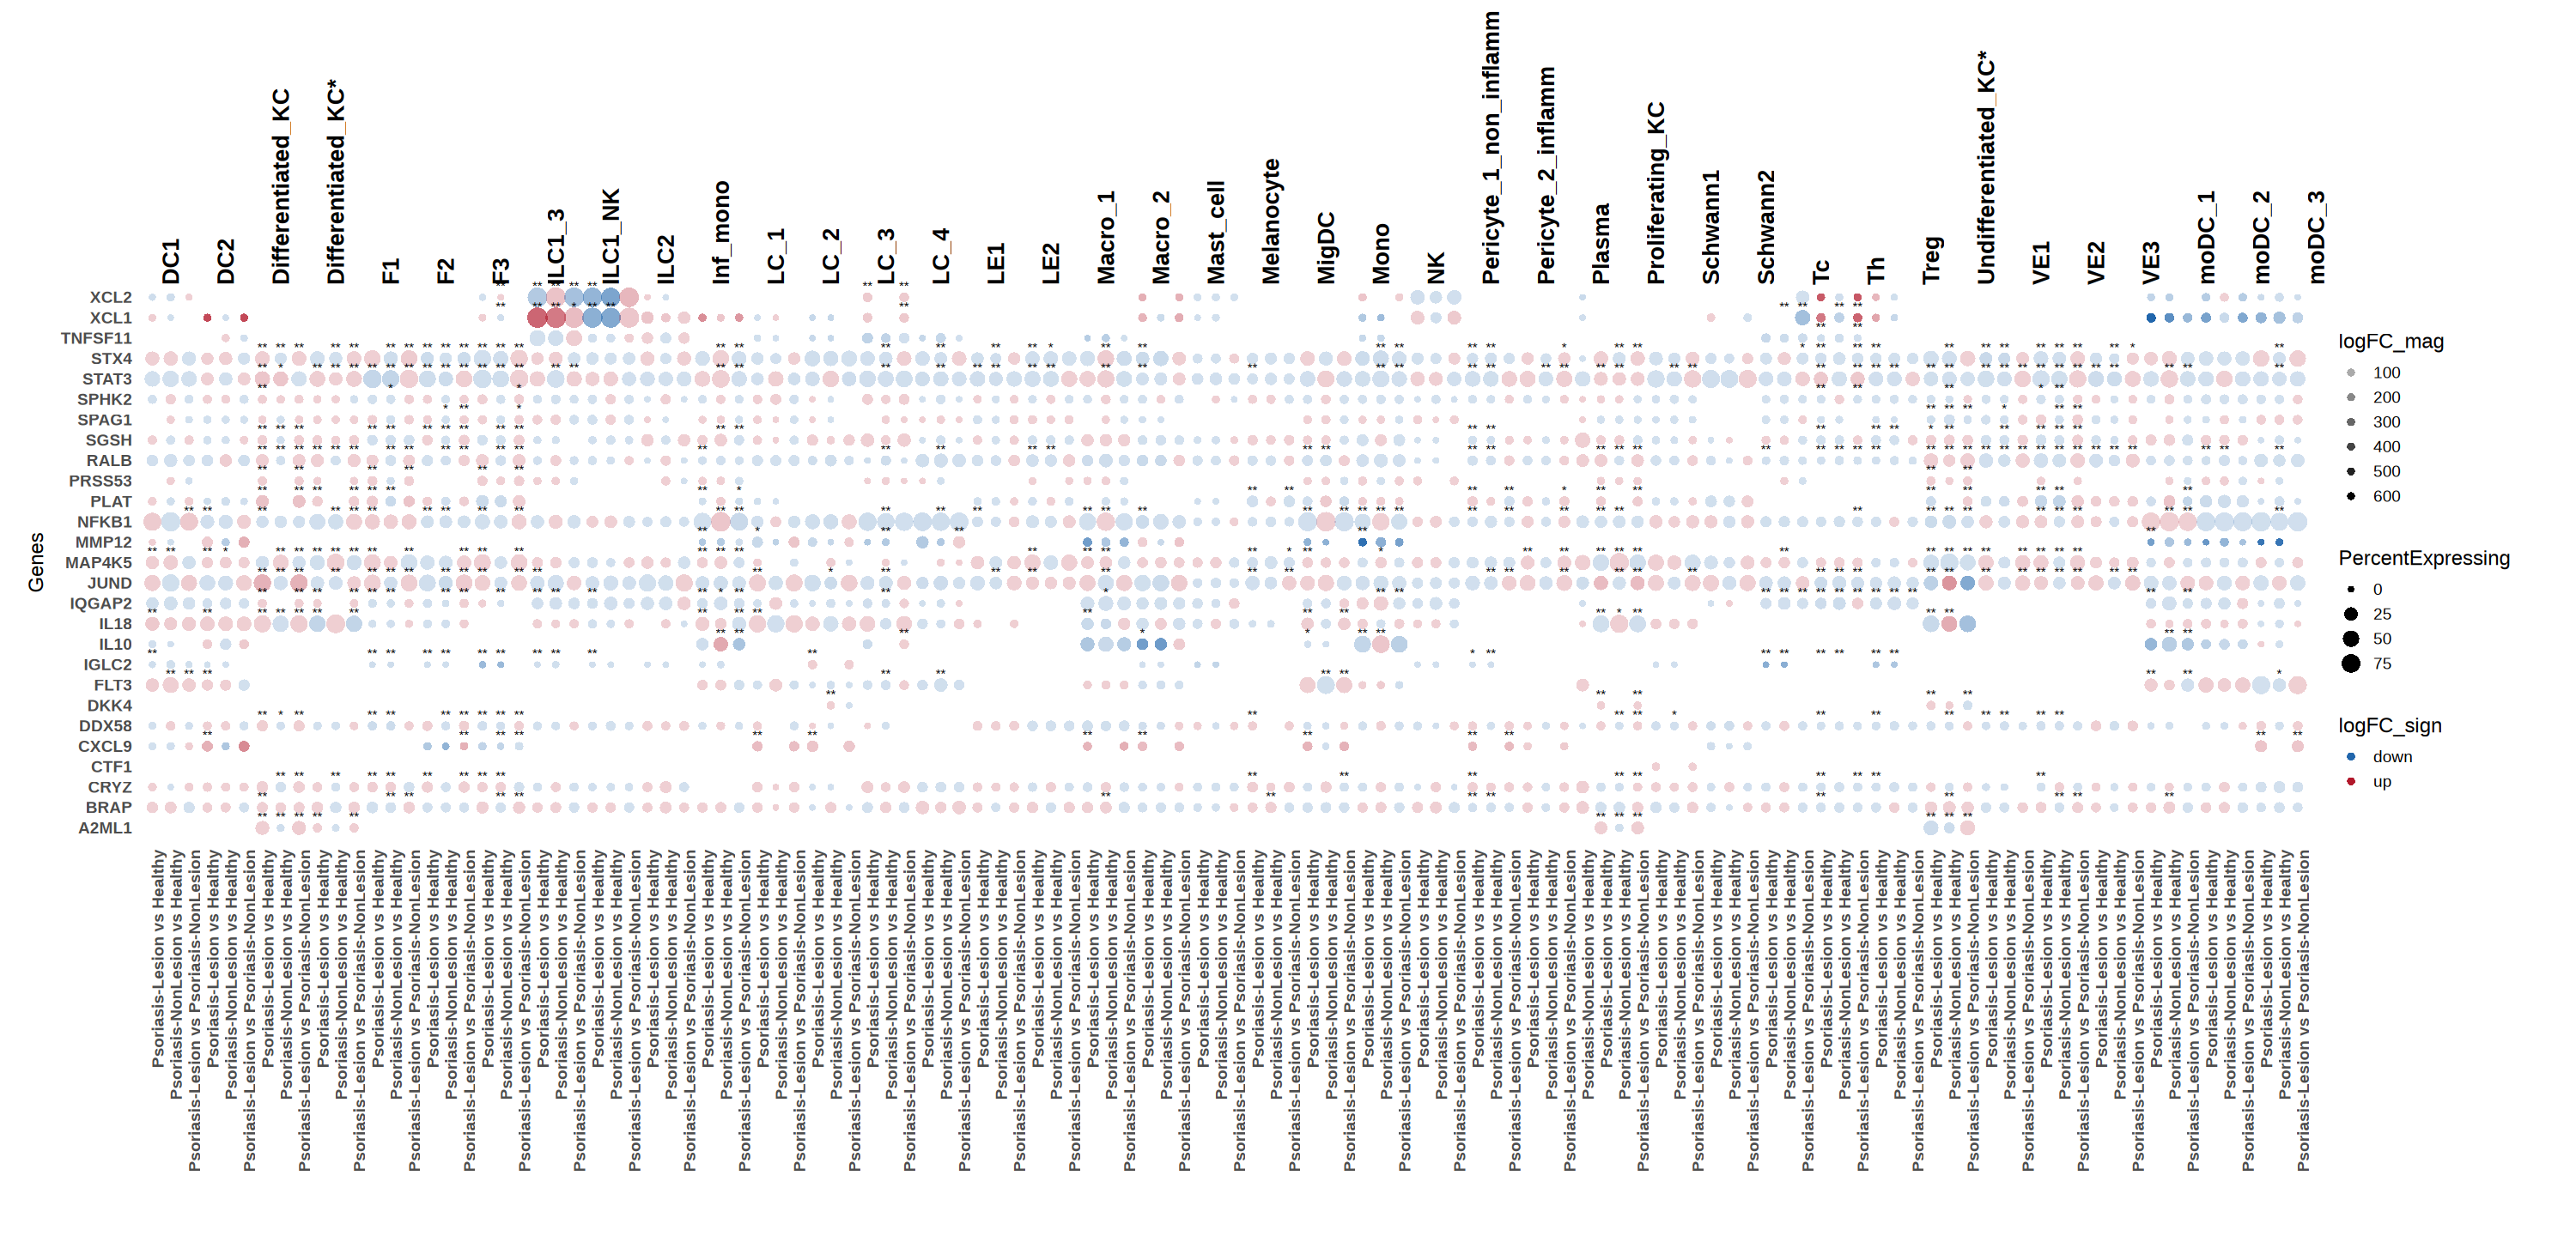

In [10]:
library(ggplot2)
library(dplyr)
library(grid)

# ============================================================
# CLEAN DATA
# ============================================================
df <- DE_celltypes %>%
    filter(!is.na(CellType), CellType != "nan") %>%   # REMOVE nan
    mutate(
        logFC_sign = ifelse(avg_log2FC > 0, "up", "down"),
        logFC_mag  = abs(avg_log2FC),
        signif = ifelse(p_val_adj < 0.01, "**",
                 ifelse(p_val_adj < 0.05, "*", "")),
        PercentExpressing = pct.1 * 100
    )

df$Comparison <- factor(
    df$Comparison,
    levels = c(
        "Psoriasis-Lesion vs Healthy",
        "Psoriasis-NonLesion vs Healthy",
        "Psoriasis-Lesion vs Psoriasis-NonLesion"
    )
)

# ============================================================
# BUILD X AXIS
# ============================================================
df$CombinedX <- paste(df$CellType, df$Comparison, sep="___")
x_levels <- unique(df$CombinedX)
df$CombinedX <- factor(df$CombinedX, levels=x_levels)

CellType_labels <- sapply(strsplit(x_levels,"___"), `[`, 1)
Comp_labels     <- sapply(strsplit(x_levels,"___"), `[`, 2)

celltypes <- unique(CellType_labels)
n_types   <- length(celltypes)
n_comp    <- length(unique(df$Comparison))


# ============================================================
# BLOCK MIDPOINTS
# ============================================================
block_centers <- sapply(seq_along(celltypes), function(i) {
    start <- (i - 1) * n_comp + 1
    end   <- start + n_comp - 1
    mean(c(start, end))
})

separator_positions <- ((1:n_types) * n_comp) + 0.5
separator_positions <- separator_positions[-length(separator_positions)]

# ============================================================
# MAIN DOT PLOT
# ============================================================
p <- ggplot(df, aes(x = CombinedX, y = Gene)) +
    geom_point(aes(color = logFC_sign, alpha = logFC_mag, size = PercentExpressing),
               shape=16) +
    geom_text(aes(label=signif), vjust=-0.8, size=3) +

    scale_color_manual(values=c("up"="#b2182b","down"="#2166ac")) +
    scale_alpha_continuous(range = c(0.2,1)) +
    scale_size(range = c(1.5, 6)) +
    scale_x_discrete(labels = Comp_labels) +

    #geom_vline(xintercept = separator_positions,
    #           linetype="dashed", color="grey40", linewidth=0.6) +

    theme_minimal(base_size = 14) +
    theme(
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1, face="bold"),
        axis.text.y = element_text(face="bold"),
        axis.title.x = element_blank(),
        panel.grid = element_blank(),
        plot.margin = margin(200, 30, 20, 20)     # <<< increase top margin
    ) +
    labs(y="Genes") +
    coord_cartesian(clip="off")   # allow text above plot


# ============================================================
# ADD ROTATED LABELS ABOVE EACH CELL TYPE BLOCK
# ============================================================

# Nudging height slightly above plot
label_y_offset <- 1.25    # 8% above top of panel

for (i in seq_along(celltypes)) {
    p <- p + annotation_custom(
        grob = textGrob(
            label = celltypes[i],
            gp = gpar(fontsize = 16, fontface = "bold"),
            rot = 90,                                 # rotate 90 degrees
            just = "left"                             # anchor label correctly
        ),
        xmin = block_centers[i],
        xmax = block_centers[i],
        ymin = Inf, ymax = Inf
    )
}

p

ggsave("DotPlot_Celltypes_90degree_nonoverlap.png", p, width=28, height=15, dpi=300)
ggsave("DotPlot_Celltypes_90degree_nonoverlap.pdf",p, width=28, height=15)


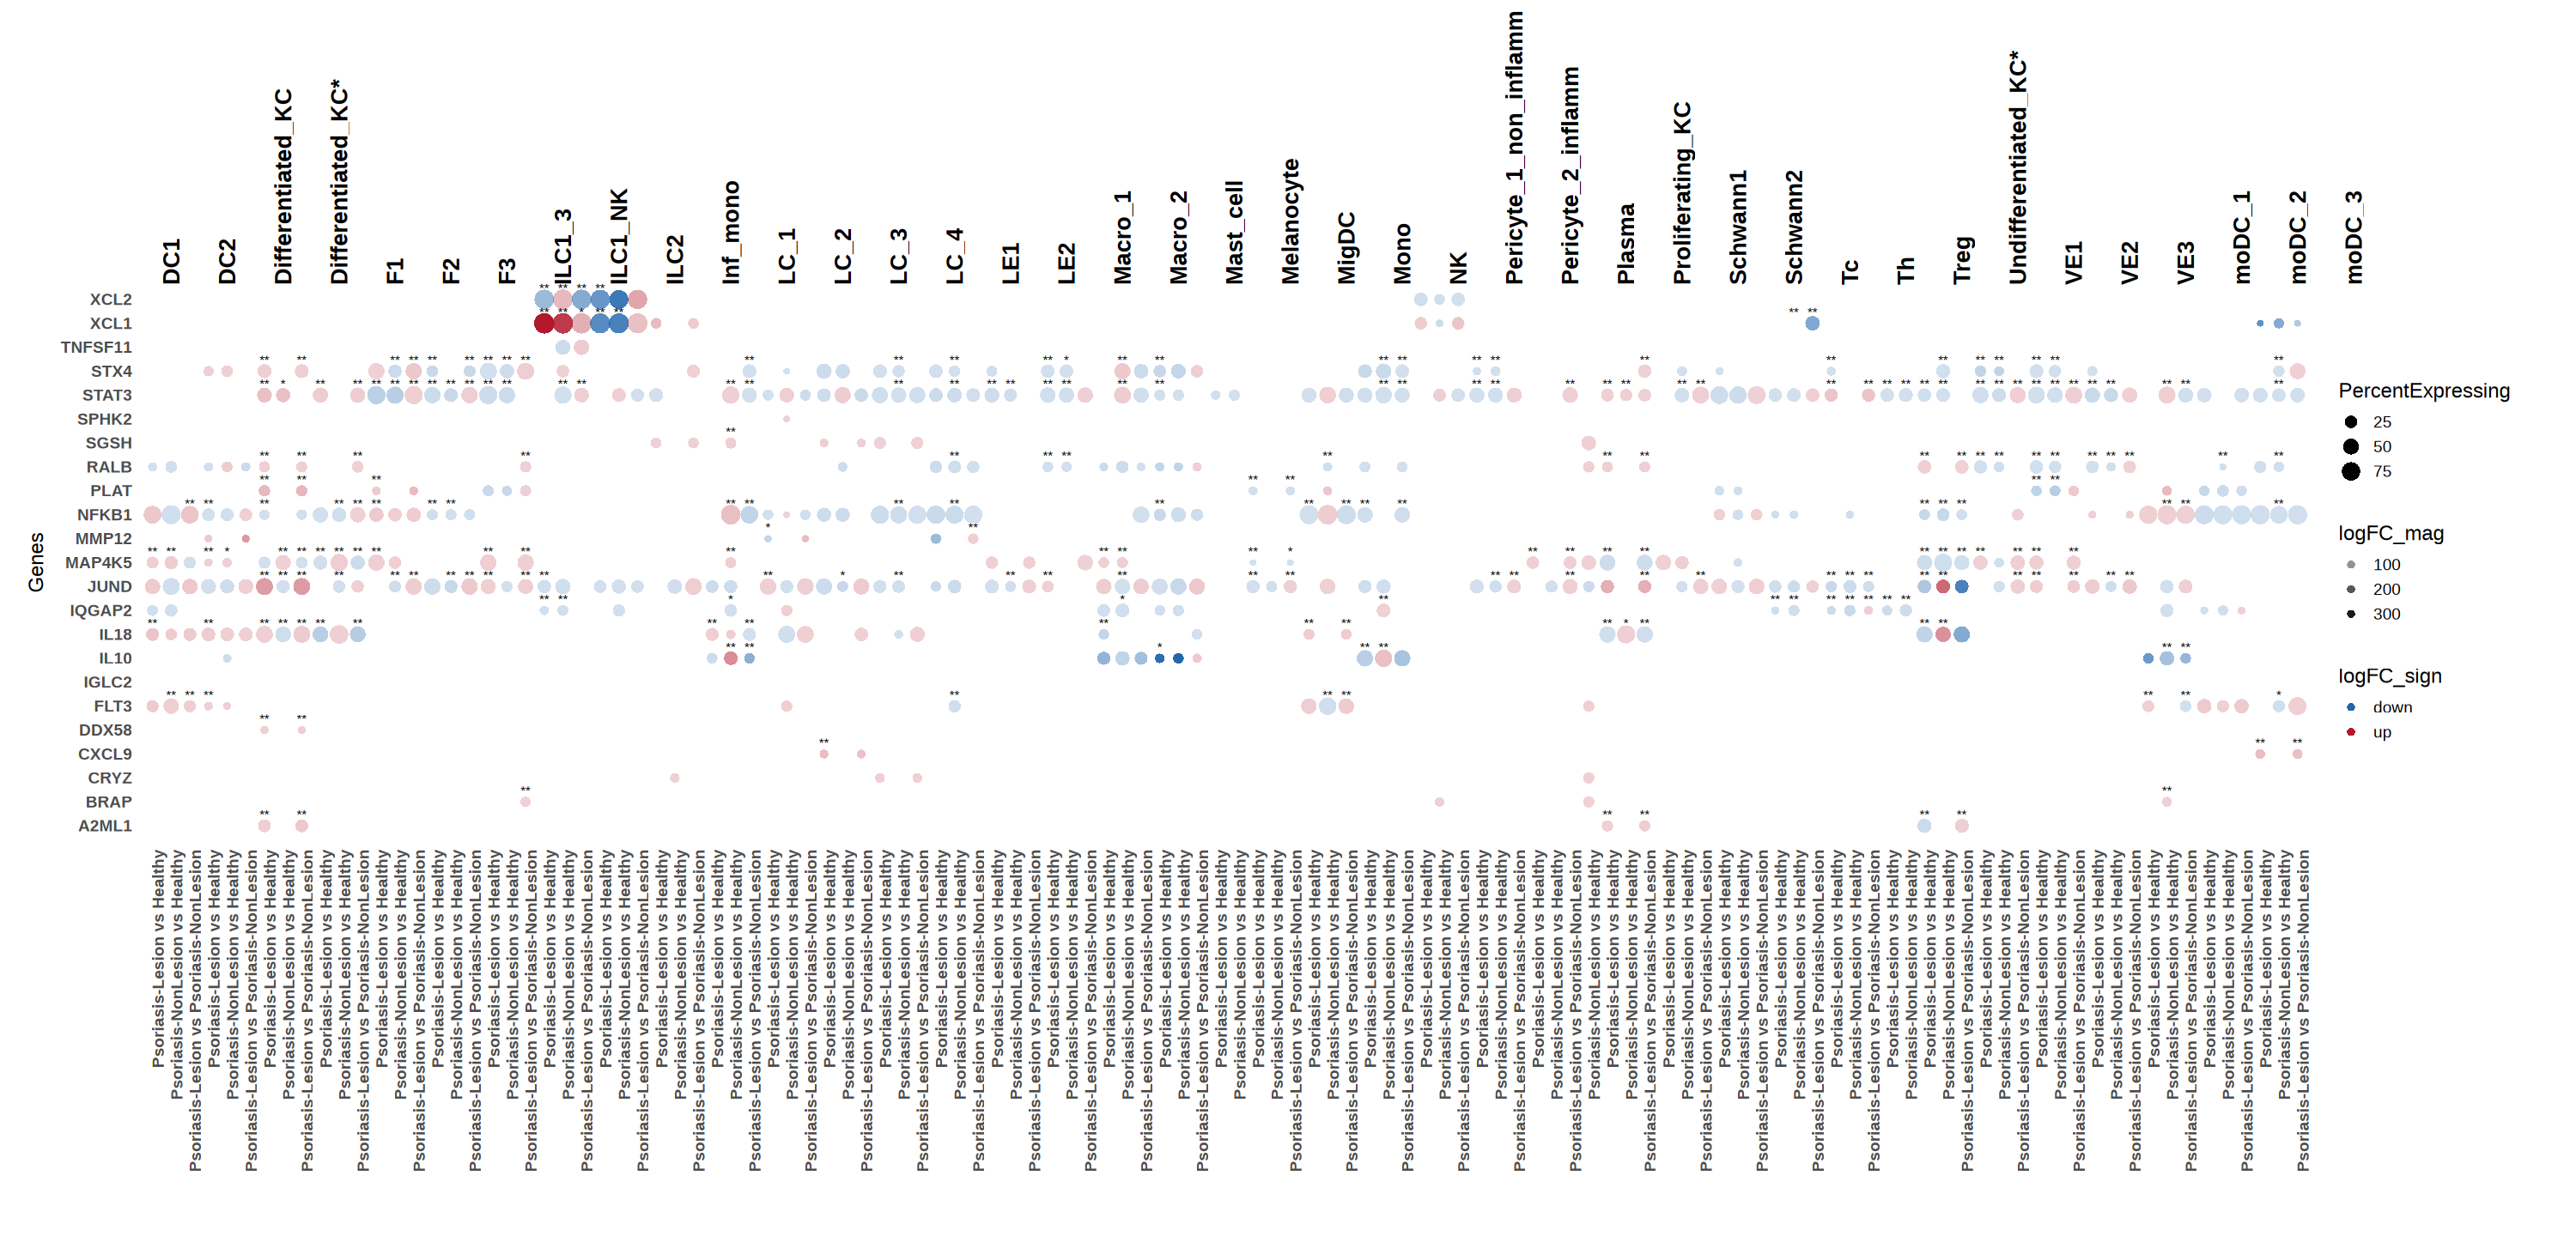

In [11]:
library(ggplot2)
library(dplyr)
library(grid)

# ============================================================
# CLEAN + FILTER DATA
# ============================================================
df <- DE_celltypes %>%
    # remove NA / "nan" cell types
    filter(!is.na(CellType), CellType != "nan") %>%

    # compute new columns
    mutate(
        logFC_sign = ifelse(avg_log2FC > 0, "up", "down"),
        logFC_mag  = abs(avg_log2FC),
        signif = ifelse(p_val_adj < 0.01, "**",
                 ifelse(p_val_adj < 0.05, "*", "")),
        PercentExpressing = pct.1 * 100
    ) %>%

    # ============================================================
    # APPLY FILTERS
    # ============================================================
    filter(
        PercentExpressing >= 10,   # keep only ≥ 10% expressing cells
        logFC_mag >= 1.5           # keep only ≥ 1.5 absolute log2FC
    )

df$Comparison <- factor(
    df$Comparison,
    levels = c(
        "Psoriasis-Lesion vs Healthy",
        "Psoriasis-NonLesion vs Healthy",
        "Psoriasis-Lesion vs Psoriasis-NonLesion"
    )
)

# ============================================================
# BUILD X AXIS
# ============================================================
df$CombinedX <- paste(df$CellType, df$Comparison, sep="___")
x_levels <- unique(df$CombinedX)
df$CombinedX <- factor(df$CombinedX, levels=x_levels)

CellType_labels <- sapply(strsplit(x_levels,"___"), `[`, 1)
Comp_labels     <- sapply(strsplit(x_levels,"___"), `[`, 2)

celltypes <- unique(CellType_labels)
n_types   <- length(celltypes)
n_comp    <- length(unique(df$Comparison))

# ============================================================
# BLOCK MIDPOINTS
# ============================================================
block_centers <- sapply(seq_along(celltypes), function(i) {
    start <- (i - 1) * n_comp + 1
    end   <- start + n_comp - 1
    mean(c(start, end))
})

separator_positions <- ((1:n_types) * n_comp) + 0.5
separator_positions <- separator_positions[-length(separator_positions)]

# ============================================================
# MAIN DOT PLOT
# ============================================================
p <- ggplot(df, aes(x = CombinedX, y = Gene)) +
    geom_point(aes(color = logFC_sign, alpha = logFC_mag, size = PercentExpressing),
               shape=16) +
    geom_text(aes(label=signif), vjust=-0.8, size=3) +

    scale_color_manual(values=c("up"="#b2182b","down"="#2166ac")) +
    scale_alpha_continuous(range = c(0.2,1)) +
    scale_size(range = c(1.5, 6)) +
    scale_x_discrete(labels = Comp_labels) +

    theme_minimal(base_size = 14) +
    theme(
        axis.text.x = element_text(angle = 90, hjust = 1, vjust = 1, face="bold"),
        axis.text.y = element_text(face="bold"),
        axis.title.x = element_blank(),
        panel.grid = element_blank(),
        plot.margin = margin(200, 30, 20, 20)
    ) +
    labs(y="Genes") +
    coord_cartesian(clip="off")


# ============================================================
# ADD ROTATED LABELS ABOVE BLOCKS
# ============================================================
for (i in seq_along(celltypes)) {
    p <- p + annotation_custom(
        grob = textGrob(
            label = celltypes[i],
            gp = gpar(fontsize = 16, fontface = "bold"),
            rot = 90,
            just = "left"
        ),
        xmin = block_centers[i],
        xmax = block_centers[i],
        ymin = Inf, ymax = Inf
    )
}

p

ggsave("DotPlot_Celltypes_90degree_nonoverlap.png", p, width=28, height=15, dpi=300)
ggsave("DotPlot_Celltypes_90degree_nonoverlap.pdf", p, width=28, height=15)
